<a href="https://colab.research.google.com/github/mannixp/Plumes/blob/main/Gaussian_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install --no-cache http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

**Content**

We first import all the packages we need to run this example

In [4]:
import numpy as np
import dedalus.public as d3
import logging
import h5py
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)

**Scalar Mixing**

We consider the case of a passive scalar $\varphi(\boldsymbol{x},t)$ in constant-density homogeneous isotropic turbulence (HIT). With $\boldsymbol{U}(\boldsymbol{x},t)$ being the velocity field, and $\Gamma$ the molecular diffusivity, the evolution equation for $\varphi(\boldsymbol{x},t)$ is
\begin{equation}
\frac{\partial \varphi}{\partial t} + \boldsymbol{U} \cdot \nabla \varphi = \Gamma \nabla^2 \varphi,
\end{equation}
such that the CDF of the scalar field is given by
\begin{equation}
F(\psi,t) = \text{Prob} \{ \varphi(x,t) < \psi\},
\end{equation}
and its pdf by $f(\psi,t) = \partial_{\psi} F(\psi , t)$. Following [Pope et al. 1985](https://www.sciencedirect.com/science/article/abs/pii/0360128585900024) the evolution equation for these distributions is given by
\begin{equation}
\frac{\partial F}{\partial t} = \Gamma \langle \nabla^2 \varphi | \psi \rangle \frac{\partial F}{\partial \psi},
\end{equation}
and
\begin{equation}
\frac{\partial f}{\partial t} = \frac{\partial }{\partial \psi} \left( \Gamma \langle \nabla^2 \varphi | \psi \rangle f \right).
\end{equation}
As $f(\psi,t)$ contains no information about space this equation is unclosed as the conditional expectation is unknown. Our aim is to apply the mapping closure developed by [Pope et al. 1991](https://link.springer.com/article/10.1007/BF00271466) to estimate a closure for the molecular mixing terms.

**Mapping Closure**

One approach to calculating $f(\psi,t),F(\psi,t)$ is to model the underlying field they describe $\varphi(\boldsymbol{x},t)$ by using a surrogate Gaussian random field $\varphi^s(\boldsymbol{x},t)$. Letting $\theta(\boldsymbol{z})$ denote a Gaussian random field such that
\begin{equation}
G(\eta) \equiv \text{Prob} \{ \theta(\boldsymbol{z}) < \eta \} = \int_{-\infty}^\eta g(s) ds, \quad \text{where} \quad g(\eta) = \frac{1}{\sqrt{2 \pi}} exp(-\frac{\eta^2}{2}),
\end{equation}
defines a standardised Gaussian of zero mean and unit variance we can determine a mapping $\varphi(\boldsymbol{x},t) = X(\theta(\boldsymbol{z}),t)$ such that
\begin{equation}
G(\eta) \equiv P(\theta < \eta) = P(X(\theta) < X(\eta)) = P(\varphi < X(\eta)) = F(X(\eta,t),t),
\end{equation}
subject to
- the CDF $F$ being a strictly increasing continuous function
- the mapping $X$ being a non-decreasing function

Subject to these two conditions we can then differentiate the last equation
\begin{equation}
F(X(\eta,t),t) = G(\eta),
\end{equation}
to obtain
\begin{equation}
\frac{ \partial F}{\partial t} = \frac{ \partial X}{\partial t} \frac{ \partial F}{\partial \psi}.
\end{equation}
Differentiating the mapping
\begin{equation}
\varphi(\boldsymbol{x},t) = X(\theta(\boldsymbol{x} J(t)),t),
\end{equation}
to obtain
\begin{equation}
\frac{\partial X}{\partial t} = \Gamma \langle \nabla^2 \varphi | \psi\rangle = \Gamma \frac{J^2(t)}{\lambda_{\theta}^2} \left( -\eta X'(\eta,t) + X''(\eta,t) \right),
\end{equation}
an approximation of the conditional expectation describing molecular mixing by exploiting the properties of the 2 point corrlation function of HIT approximated here as a Gaussian field namely that for
\begin{equation}
\rho(r) = \langle \theta(\boldsymbol{z}) \theta(\boldsymbol{z} + \boldsymbol{e}r) \rangle
,
\end{equation}
we have the properties
- $-lim_{r \to 0} \frac{\partial^2 \rho(r)}{\partial r^2} = \left\langle \frac{\partial \theta}{\partial z_i} \frac{\partial \theta}{\partial z_i} \right\rangle = \lambda_{\theta}^{-2}, $
- $\left\langle \frac{\partial \theta}{\partial z_i} \frac{\partial \theta}{\partial z_i} \middle\vert \theta = \eta  \right\rangle = \lambda_{\theta}^{-2}, $
- $\left\langle \frac{\partial^2 \theta}{\partial z_i^2} \middle\vert \theta = \eta  \right\rangle = -\frac{\eta}{\lambda_{\theta}^2}.$

**An example**

As a test of this method we consider the mixing of the initial condition $\varphi(\boldsymbol{x},t=0)$ consisting of blobs of fluid at $\varphi = \pm 1$ such that
\begin{equation}
f(\psi,t=0) = 1/2[ \delta(\psi-1)+ \delta(\psi+1)],
\end{equation}
and
\begin{equation}
X(\eta,t=0) = 2H(\eta,0) - 1.
\end{equation}

Below we numerically solve the mapping's parabolic evolution equation derived above subject to the Neumann boundary conditions $\partial_{\eta} X = 0$ at $\pm \infty$ or numerically the limits of the finite domain. Solving this equation we obtain a numerical approximation $X(\eta_i,t_n)$ on the sample space $\eta_n$ and time $t_i$ grids.

In [115]:
def Derivatives(N,dx):


  D = np.zeros((N,N))
  for i in range(N):
    if i < N-1:
      D[i,i+1] = 1
    if i > 0:
      D[i,i-1] =-1

  L = np.zeros((N,N))
  for i in range(N):

    L[i,i] = -2.
    if i ==N-1:
      L[i,i-1] = 2
      #L[i,i-1] = 1
    elif i == 0:
      L[i,i+1] = 2
      #L[i,i+1] = 1
    else:
      L[i,i-1] = 1
      L[i,i+1] = 1

  return D/(2*dx), L/(dx**2)

def Map_Solver(X_0, η,dη, T,Δt, J = lambda t: 1):

  N_η = len(η)
  N_T = len(T)

  D_η, L_η  = Derivatives(N_η,dη)
  L         = -np.diag(η)@D_η + L_η
  I         = np.eye(L.shape[0])

  A = lambda t: I/Δt - J(t)*L/2
  B = lambda t: I/Δt + J(t)*L/2

  X      = np.zeros((N_T,N_η))
  X[0,:] = X_0
  for n,t in enumerate(T[:-1]):
    X[n+1,:] = np.linalg.solve(A(t),B(t)@X[n,:])

  return X;

# Domain
N_η  = 128
N_T  = 10**3
η,dη = np.linspace(-2,2,N_η,retstep=True);
T,Δt = np.linspace( 0,1,N_T,retstep=True);

# Initial condition
X_0 = 2*np.heaviside(η,0) - 1

# Solve
X   = Map_Solver(X_0, η,dη, T,Δt, J = lambda t: 1)

Having solved for $X(\eta_n,t_i)$ we then use this to recover the CDF by differentiating
\begin{equation}
\partial_{\eta} \left( F(X(\eta,t),t) - G(\eta) \right) = f(X(\eta,t),t) \frac{\partial X}{\partial \eta} - g(\eta) = 0,
\end{equation}
and rearranging in terms of $f$ to obtain
\begin{equation}
f(X(\eta,t),t)  = g(\eta)/ \frac{\partial X}{\partial \eta}.
\end{equation}
Below we plot the time evolution of $f(X(\eta,t),t)$ recovered in this manner as well as integrating it over sample space to check it defines a pdf.

<ipython-input-116-f3c14a3c1205>:9: RuntimeWarning: divide by zero encountered in divide
  f = g(η[1:-1])/dXdη[n,1:-1]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4978: RuntimeWarning: invalid value encountered in multiply
  ret = (d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0).sum(axis)


int f dx  nan 



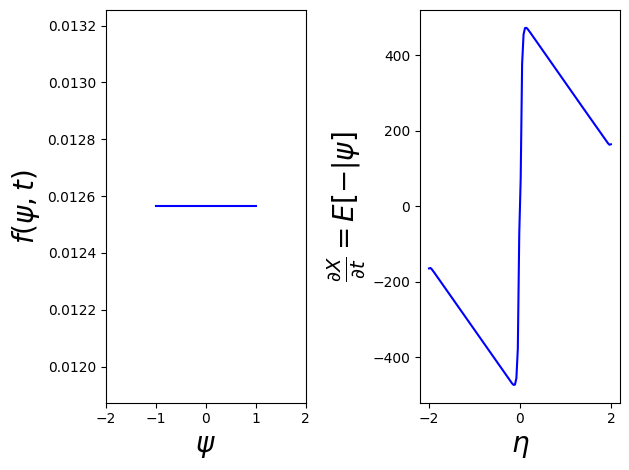

int f dx  0.9509053754816853 



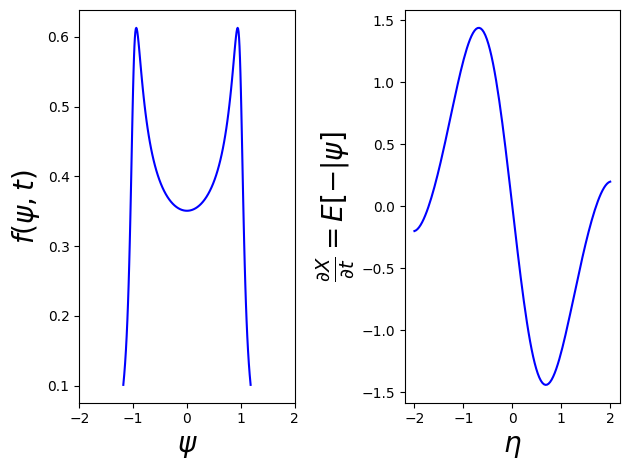

int f dx  0.9509457189147617 



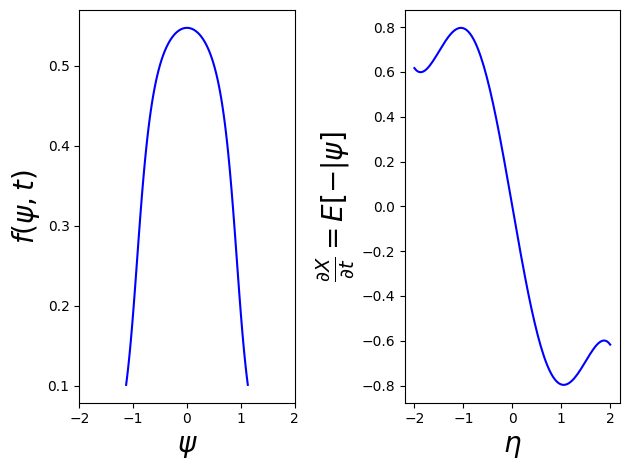

int f dx  0.9509614160967683 



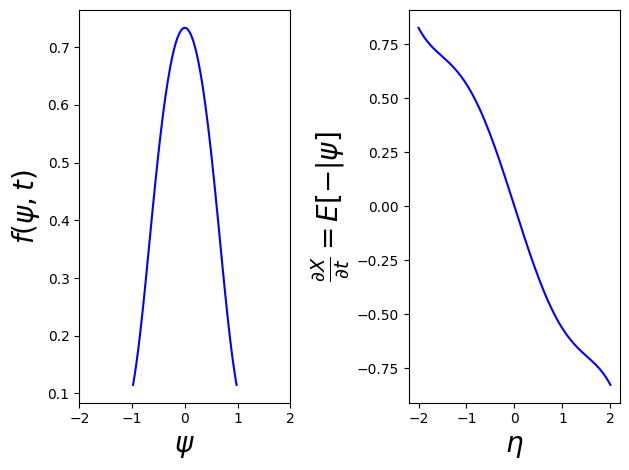

int f dx  0.950966942112818 



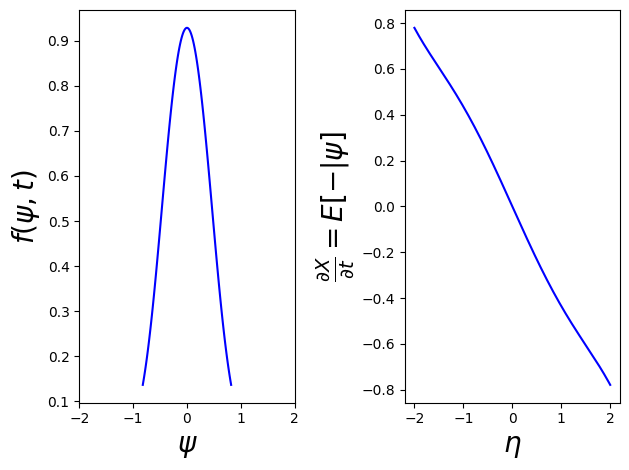

In [116]:
# Create the map from X to f
D_η, L_η  = Derivatives(N_η,dη)
dXdη = ( D_η@(X.T) ).T
g    = lambda η: (1./np.sqrt(2*np.pi) )*np.exp(-.5*(η**2))

# Plot
for n,t in enumerate(T[:-2]):

  f = g(η[1:-1])/dXdη[n,1:-1]

  if (n%(N_T//5) == 0):

    print('int f dx ',np.trapz(y=f,x=X[n,1:-1]),'\n')

    fig, (ax1,ax2) = plt.subplots(1,2)

    ax1.plot(X[n,1:-1],f,'b-',label=r'$f(X(\eta,t),t)$')
    ax1.set_xlabel(r'$\psi$',fontsize=20)
    ax1.set_ylabel(r'$f(\psi,t)$',fontsize=20)
    ax1.set_xlim([-2,2])

    ax2.plot(η, (X[n+1,:]  -X[n-1,:])/(2.*Δt),'b-')
    ax2.set_xlabel(r'$\eta$',fontsize=20)
    ax2.set_ylabel(r'$\frac{\partial X}{\partial t} = E[-|\psi]$',fontsize=20)

    plt.tight_layout()
    plt.show()

**DNS estimation**

We now turn to estimating the conditional expectation using direct numerical simulation.

**Gaussian Random field**

To create an approximation of homogeneous isotropic turbulence (HIT) we use a *scale-free* Gaussian random field. We let $\varphi$ be a real valued stationary Gaussian field on $\mathbb{R}^d$ such that for all $x \in \mathbb{R}^d$, $\varphi(x)$ defines a random variable and $(\varphi(x), x \in \mathbb{R}^d)$ defines a family of indentically distributed random variables on the probability space $(\Omega, \mathcal{F}, P)$. Such a random field is then completely characterised by its mean and covariance
\begin{align*}
\mu  &= \mathbb{E}(\varphi(0)) = \mathbb{E}(\varphi(x)), \\
C(x) &= \mathbb{E}(\varphi(0)\varphi(x)) - \mu^2 = \mathbb{E}(\varphi(x)\varphi(x+y)) - \mu^2, \quad \forall \quad x,y \in \mathbb{R}^d.
\end{align*}
To generate $\varphi$ we make use of $W$ a Gaussian White noise random field on $\mathbb{R}^d$ such that $\mathbb{E}(W(x)W(y)) = \delta(x-y)$. Letting the Fourier transform of this white noise process be defined as
\begin{equation}
FW(k) \equiv F \circ W(x) = \int_{\mathbb{R}^d} e^{2 \pi i (k,x)} W(x) dx,
\end{equation}
we can then write
\begin{equation}
\varphi(x) = (F^{-1} P F W)(x),
\end{equation}
where
\begin{equation}
P(k) = \int C(x) e^{ikx} dx,
\end{equation}
is the power spectrum of the correlation function. Below we implement two examples using the scale free power law spectrum $P(k) = |k|^{-\alpha}$. As the power spectrum that falls off like a power law and the structures in these fields are typically fractal they do not distinguish any particular length scale. Some nice texts on this topic are [1](https://structures.uni-heidelberg.de/blog/posts/gaussian-random-fields/index.php), [2](https://arxiv.org/pdf/1105.2737) and [3](https://andrewwalker.github.io/statefultransitions/post/gaussian-fields/).

In [85]:
def fftIndgen(n):
  a = np.arange(0, n//2 + 1)
  b = np.arange(1, n//2)[::-1]
  b = [-i for i in b]
  return np.hstack((a,b))

def gaussian_random_field_2D(Pk = lambda k : k**-3.0, size = 100):

  def Pk2(kx, ky):
    if kx == 0 and ky == 0:
      return 0.0
    return np.sqrt(Pk(np.sqrt(kx**2 + ky**2)))

  W  = np.random.normal(size = (size, size))
  FW = np.fft.fft2(W)

  P_k = np.zeros((size,size))
  for i, kx in enumerate(fftIndgen(size)):
    for j, ky in enumerate(fftIndgen(size)):
      P_k[i, j] = Pk2(kx, ky)

  return np.fft.ifft2(P_k * FW).real

def gaussian_random_field_1D(Pk = lambda k : k**-3.0, size = 100):

  def Pk2(kx):
    if kx == 0:
      return 0.0
    return np.sqrt(Pk(np.sqrt(kx**2)))

  W  = np.random.normal(size = (size,))
  FW = np.fft.fft(W)

  P_k = np.zeros(size)
  for i, kx in enumerate(fftIndgen(size)):
    P_k[i] = Pk2(kx)

  return np.fft.ifft(P_k * FW).real

Having generated a HIT field we now pass this to the scalar advection diffusion equation which we time integrate over the interval $t \in [0,1]$ in a two-dimensional periodic box $\Pi^2$, with the velocity field and initial conditions given by the power spectrum
\begin{equation}
P(\boldsymbol{k}) = |\boldsymbol{k}|^{-5/3}.
\end{equation}
As an initial condition we prescribe a sharp interface,
\begin{equation}
\varphi(\boldsymbol{x},t=0) = \tanh(10\boldsymbol{x}).
\end{equation}
*NOTE: This takes about 3 minutes to run.*

In [86]:
# Parameters
Γ  = 1;  # Equivalent to Peclet number
α  = -5./3.
Nx = 64;   # This can be reduced but it will increase the noise in the histogram
stop_sim_time = 1
timestep = 1e-03

# Domain
coords = d3.CartesianCoordinates('x','y')
dist   = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(-np.pi, np.pi), dealias=3/2)
ybasis = d3.RealFourier(coords['y'], size=Nx, bounds=(-np.pi, np.pi), dealias=3/2)

# Fields
S = dist.Field(name='S', bases=(xbasis,ybasis))
U = dist.VectorField(coords, name='U', bases=(xbasis,ybasis))
x,y = dist.local_grids(xbasis,ybasis)

# Flow - not divergence free!!
U['g'][0] = gaussian_random_field_2D(Pk = lambda k : k**α, size = Nx)
U['g'][1] = gaussian_random_field_2D(Pk = lambda k : k**α, size = Nx)

# Initial condition
S['g']    = np.tanh(20*(x + y)) #gaussian_random_field_2D(Pk = lambda k : k**α, size = Nx)

# Problem
grad_S  = d3.grad(S)
problem = d3.IVP([S], namespace=locals())
problem.add_equation("dt(S) - Γ*div(grad_S) = -U@grad(S)") #

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = stop_sim_time

# Flow properties
snapshots = solver.evaluator.add_file_handler('snapshots', iter=1)
snapshots.add_task(S,      layout='g',name='S',scales=3/2)
snapshots.add_task(Γ*d3.div(grad_S), layout='g',name='Lap_S',scales=3/2)

# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)

        if (solver.iteration-1) % 100 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e'%(solver.iteration, solver.sim_time, timestep))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 3.8e+01/s


2024-05-13 12:28:09,409 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 3.8e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


2024-05-13 12:28:09,489 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 3.4e+01/s


2024-05-13 12:28:09,618 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 3.4e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 1s, Rate: 3.4e+01/s


2024-05-13 12:28:09,736 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 1s, Rate: 3.4e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+01/s


2024-05-13 12:28:09,835 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2024-05-13 12:28:09,931 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2024-05-13 12:28:10,047 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2024-05-13 12:28:10,160 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2024-05-13 12:28:10,276 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:__main__:Starting main loop


2024-05-13 12:28:10,291 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.000000e-03, dt=1.000000e-03


2024-05-13 12:28:10,397 __main__ 0/1 INFO :: Iteration=1, Time=1.000000e-03, dt=1.000000e-03


INFO:__main__:Iteration=101, Time=1.010000e-01, dt=1.000000e-03


2024-05-13 12:28:12,068 __main__ 0/1 INFO :: Iteration=101, Time=1.010000e-01, dt=1.000000e-03


INFO:__main__:Iteration=201, Time=2.010000e-01, dt=1.000000e-03


2024-05-13 12:28:13,528 __main__ 0/1 INFO :: Iteration=201, Time=2.010000e-01, dt=1.000000e-03


INFO:__main__:Iteration=301, Time=3.010000e-01, dt=1.000000e-03


2024-05-13 12:28:14,939 __main__ 0/1 INFO :: Iteration=301, Time=3.010000e-01, dt=1.000000e-03


INFO:__main__:Iteration=401, Time=4.010000e-01, dt=1.000000e-03


2024-05-13 12:28:16,300 __main__ 0/1 INFO :: Iteration=401, Time=4.010000e-01, dt=1.000000e-03


INFO:__main__:Iteration=501, Time=5.010000e-01, dt=1.000000e-03


2024-05-13 12:28:17,690 __main__ 0/1 INFO :: Iteration=501, Time=5.010000e-01, dt=1.000000e-03


INFO:__main__:Iteration=601, Time=6.010000e-01, dt=1.000000e-03


2024-05-13 12:28:19,146 __main__ 0/1 INFO :: Iteration=601, Time=6.010000e-01, dt=1.000000e-03


INFO:__main__:Iteration=701, Time=7.010000e-01, dt=1.000000e-03


2024-05-13 12:28:20,524 __main__ 0/1 INFO :: Iteration=701, Time=7.010000e-01, dt=1.000000e-03


INFO:__main__:Iteration=801, Time=8.010000e-01, dt=1.000000e-03


2024-05-13 12:28:22,329 __main__ 0/1 INFO :: Iteration=801, Time=8.010000e-01, dt=1.000000e-03


INFO:__main__:Iteration=901, Time=9.010000e-01, dt=1.000000e-03


2024-05-13 12:28:24,328 __main__ 0/1 INFO :: Iteration=901, Time=9.010000e-01, dt=1.000000e-03


INFO:solvers:Simulation stop time reached.


2024-05-13 12:28:25,785 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1000


2024-05-13 12:28:25,790 solvers 0/1 INFO :: Final iteration: 1000


INFO:solvers:Final sim time: 1.0000000000000007


2024-05-13 12:28:25,794 solvers 0/1 INFO :: Final sim time: 1.0000000000000007


INFO:solvers:Setup time (init - iter 0): 0.9561 sec


2024-05-13 12:28:25,797 solvers 0/1 INFO :: Setup time (init - iter 0): 0.9561 sec


INFO:solvers:Warmup time (iter 0-10): 0.3014 sec


2024-05-13 12:28:25,799 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.3014 sec


INFO:solvers:Run time (iter 10-end): 15.19 sec


2024-05-13 12:28:25,801 solvers 0/1 INFO :: Run time (iter 10-end): 15.19 sec


INFO:solvers:CPU time (iter 10-end): 0.004219 cpu-hr


2024-05-13 12:28:25,803 solvers 0/1 INFO :: CPU time (iter 10-end): 0.004219 cpu-hr


INFO:solvers:Speed: 5.174e+05 mode-stages/cpu-sec


2024-05-13 12:28:25,806 solvers 0/1 INFO :: Speed: 5.174e+05 mode-stages/cpu-sec


Having time integrated the transport equation for the scalar concentration we have a set of snapshots $\varphi(\boldsymbol{x},t)$ at discrete time intervals $t_n$. Loading the numerical snapshots saved below we now use this data to calculate the terms in this equation.

In [87]:
# Data loading
file   = h5py.File('./snapshots/snapshots_s1.h5', mode='r')
times  = file['tasks/S'].dims[0][0][:]
x_data = file['tasks/S'].dims[1][0][:]
y_data = file['tasks/S'].dims[2][0][:]
S_data = file['tasks/S'][:,...]
Lap_S_data = file['tasks/Lap_S'][:,...]

# plt.figure()
# plt.imshow(S_data[-1,...], interpolation='none')

Using the data, we then estimate the CDF $F(\psi,t)$, PDF $f(\psi,t)$ and the conditional average $\Gamma\langle \nabla^2 \varphi | \psi \rangle$ at each time-step using a histogram.

time (s) =  0.10000000000000007 



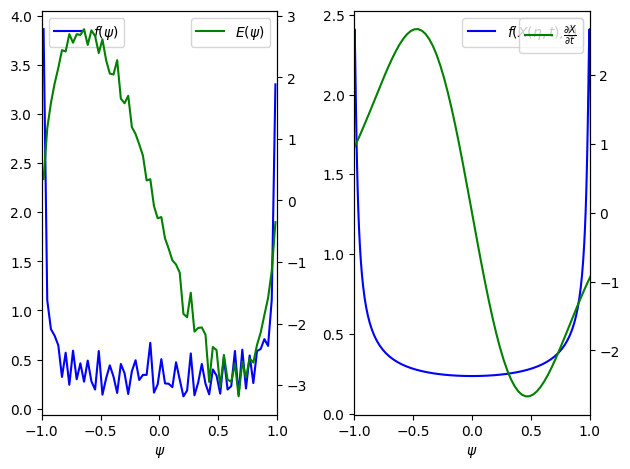

time (s) =  0.20000000000000015 



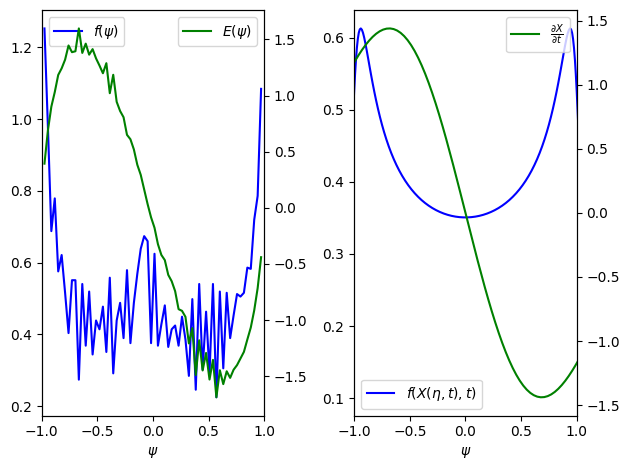

time (s) =  0.3000000000000002 



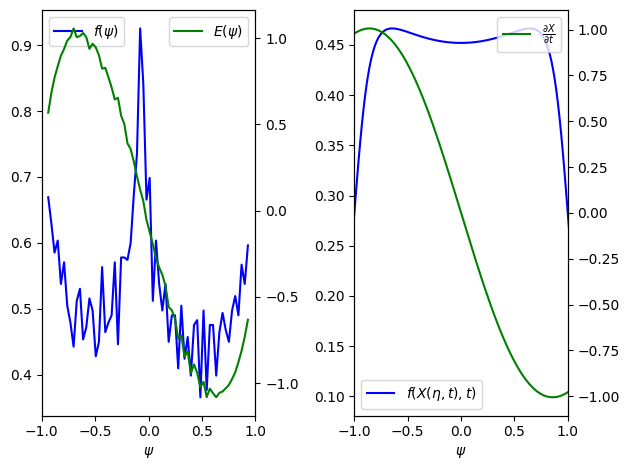

time (s) =  0.4000000000000003 



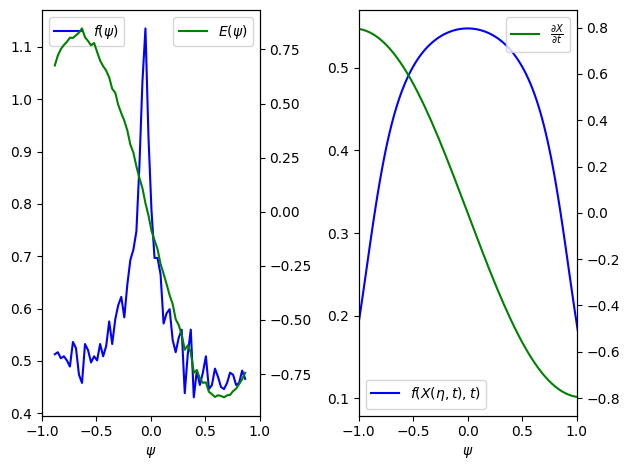

time (s) =  0.5000000000000003 



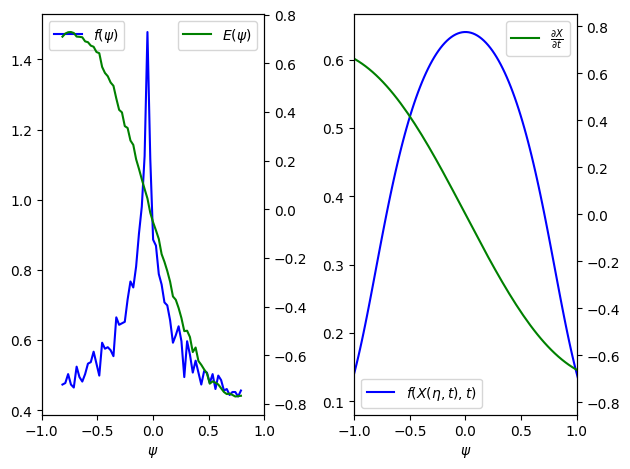

time (s) =  0.6000000000000004 



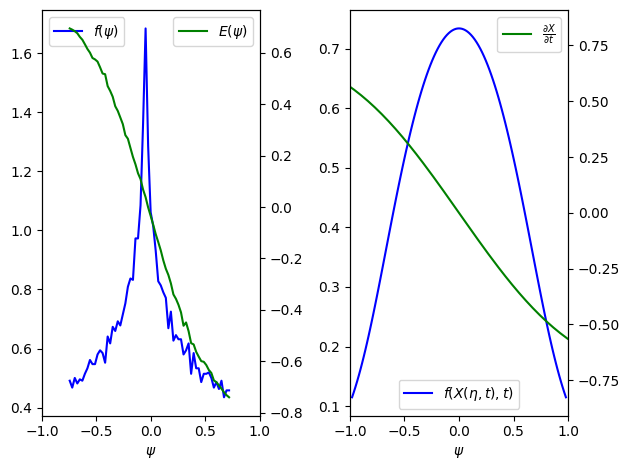

time (s) =  0.7000000000000005 



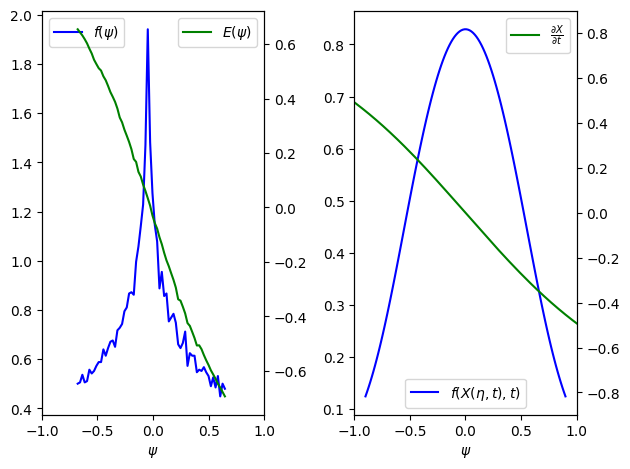

time (s) =  0.8000000000000006 



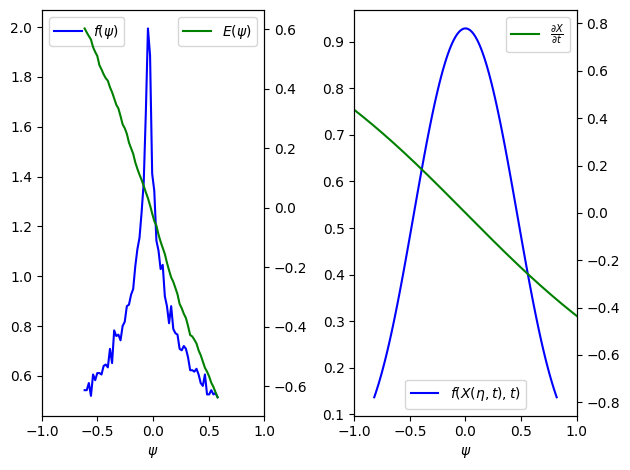

time (s) =  0.9000000000000007 



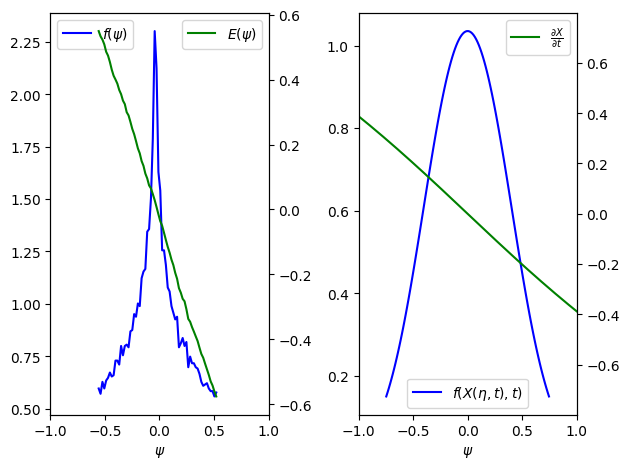

In [122]:
N_bins = 64

def PDF(S_data,t,N_bins):

  f,s= np.histogram(S_data[t,...].flatten(), bins=N_bins,density=True); # n + 1 (-2)
  s  = 0.5*(s[1:] + s[:-1]); ds = s[1] - s[0];
  F  = np.cumsum(f)*ds

  return F,f,s

def D2(S_data,Lap_S_data,t, N_bins):

  f_SΦ,s,φ = np.histogram2d(S_data[t,...].flatten(), Lap_S_data[t,...].flatten(),bins=N_bins,density=True) # n (-3)
  φ = .5*(φ[1:]+φ[:-1]); dφ = φ[1] - φ[0];
  s = .5*(s[1:]+s[:-1]); ds = s[1] - s[0];
  f_S =  np.sum(  f_SΦ,axis=1)*dφ     # f_S(s)
  E   = (np.sum(φ*f_SΦ,axis=1)*dφ)/f_S; # E{Φ|S} = int_φ f_Φ|S(φ|s)*φ dφ

  return E

for n,t in enumerate(times):

  if (n%100 == 0) and (n != 0):

    print('time (s) = ',t,'\n')
    F,f,s = PDF(S_data,n,N_bins)
    E = D2(S_data,Lap_S_data,n, N_bins)

    fig, (ax1,ax2) = plt.subplots(1,2)

    ax1.plot(s,f,'b-',label=r'$f(\psi)$')
    ax1.legend(loc=2)
    ax1R = ax1.twinx()
    ax1R.plot(s,E,'g-',label=r'$E(\psi)$')
    ax1R.legend(loc=1)
    ax1.set_xlabel(r'$\psi$')
    ax1.set_xlim([-1,1])
    #ax1.set_ylim([0,1.5])


    f = g(η[1:-1])/dXdη[n,1:-1]
    ax2.plot(X[n,1:-1],f,'b-',label=r'$f(X(\eta,t),t)$')
    ax2.legend()
    ax2R = ax2.twinx()
    ax2R.plot(η, (X[n+1,:]  -X[n-1,:])/(2.*Δt),'g-',label=r'$\frac{\partial X}{\partial t}$')
    ax2R.legend()
    ax2.set_xlabel(r'$\psi$')
    ax2.set_xlim([-1,1])
    #ax2.set_ylim([0,1.5])

    plt.tight_layout()
    plt.show()